In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install -qU python-gdcm pydicom pylibjpeg

In [3]:
!pip install python-gdcm

In [5]:
!pip install -U python-gdcm

In [6]:
from functools import partial
import multiprocessing as mp
from pathlib import Path
import numpy as np
import pandas as pd
import pydicom
from skimage.transform import resize
import tqdm
import matplotlib.pyplot as plt 

import gdcm
import pylibjpeg


In [7]:
# RESCALE_TO = (512, 512)
RESCALE_TO = (256, 256)
DATA_PATH = Path("/kaggle/input/rsna-breast-cancer-detection")
TRAINING_IMAGES = DATA_PATH.joinpath("train_images").iterdir()
TRAINING_DATA = DATA_PATH.joinpath("train.csv")
TEST_IMAGES = DATA_PATH.joinpath("test_images").iterdir()
TEST_DATA = DATA_PATH.joinpath("test.csv")

In [8]:
training_data_df = pd.read_csv(TRAINING_DATA)
training_data_df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [9]:
cancerous =training_data_df[(training_data_df['cancer']==1)].tail(100)
non_cancerous=training_data_df[(training_data_df['cancer']==0)].head(100)
tr_img=pd.concat([cancerous, non_cancerous],axis=0)
tr_img

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
50949,2,64930,1754969656,R,MLO,75.0,1,1,0,NaN,0,NaN,21,False
50950,2,64930,2024346917,R,CC,75.0,1,1,0,NaN,0,NaN,21,False
50969,2,64956,1305773827,L,MLO,51.0,1,1,0,NaN,0,NaN,48,False
50970,2,64956,1997115272,L,CC,51.0,1,1,0,NaN,0,NaN,48,False
51090,1,65077,94523874,R,MLO,74.0,1,1,0,0.0,0,B,49,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2,10136,1638919168,L,MLO,46.0,0,0,0,0.0,0,NaN,48,True
100,2,10136,1520248094,R,MLO,46.0,0,0,0,NaN,0,NaN,48,False
101,2,10136,1626006836,R,CC,46.0,0,0,0,NaN,0,NaN,48,False
102,1,1014,629904228,L,MLO,76.0,0,0,0,1.0,0,B,49,False


In [10]:
def dicom_file_to_data(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    resized_image = resize(data, (RESCALE_TO))
    data = (resized_image -resized_image.min()) / (resized_image.max() - resized_image.min())
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1 - data
    return data * dicom.RescaleSlope + dicom.RescaleIntercept  #Already in hounse field unit

In [11]:
TR_IMAGES = []
TR_DATA = []


for i,row in tqdm.tqdm(tr_img.iterrows()):
    patient_id = row['patient_id']
    image_id = row['image_id']
    original_path='/kaggle/input/rsna-breast-cancer-detection/train_images'
    img_path =  f'{original_path}/{patient_id}/{image_id}.dcm'
    
    
    dicom = pydicom.read_file(img_path)
    data = dicom.pixel_array
    resized_image = resize(data, (RESCALE_TO))
    data = (resized_image -resized_image.min()) / (resized_image.max() - resized_image.min())
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1 - data
    data=data * dicom.RescaleSlope + dicom.RescaleIntercept  #Already in hounse field unit
   
    TR_IMAGES.append(data)
    TR_DATA.append(tr_img['cancer'].iloc[0])




200it [07:21,  2.21s/it]


In [13]:
print(len(TR_IMAGES))
print(len(TR_DATA))

200
200


In [14]:
TR_IMAGES=np.array(TR_IMAGES)
TR_DATA= np.array(TR_DATA)

In [15]:
type(TR_IMAGES)


numpy.ndarray

In [16]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import numpy as np



In [17]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3),activation='relu',input_shape=(256,256,1)))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64,(3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

X_train, X_test, y_train, y_test = train_test_split(TR_IMAGES, TR_DATA,shuffle=True)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])


#X_train = np.asarray(X_train).astype(np.float32)
#X_test   = np.asarray(X_test).astype(np.float32)
X_train=tf.convert_to_tensor(X_train, dtype=tf.float32)

X_train = np.expand_dims(X_train, axis=-1)
X_test=np.expand_dims(X_test, axis=-1)

2023-01-14 22:04:32.312454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 22:04:32.313666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 22:04:32.490131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 22:04:32.491392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 22:04:32.492471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [19]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [20]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
type(y_train)

150
150
50
50


numpy.ndarray

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      4672      
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1000000)           0         
_________________________________________________________________
dense (Dense)                (None, 100)               100000100 
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

In [22]:
model.fit(X_train,y_train, epochs=20, verbose=2) #validation_data=(X_test, y_test)

2023-01-14 22:05:50.585918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-01-14 22:05:52.367653: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5/5 - 10s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 11/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 12/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 13/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 14/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 15/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 16/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 17/20
5/5 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 18/20
5/5 

In [23]:
results = model.evaluate(X_test, y_test)
results

2/2 [==============================] - 0s 144ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [25]:
y_pred = model.predict(X_test)
y_pred

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [26]:
len(y_pred)

50

In [27]:
len(y_test)

50

In [28]:
import sklearn.metrics as metrics

In [29]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred) 

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (2).

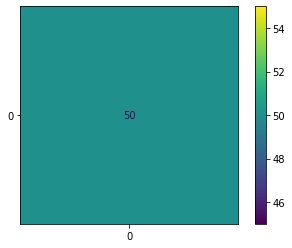

In [30]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()